# Research sandbox

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})) \},$ \
$V'(s) = H(s -s_{\text{jam}})\lambda\exp(-\lambda v_0^{-1}(s -s_{\text{jam}})),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_{\text{jam}},\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +\sigma_R\sqrt{2 b^{-1}} \xi_n,\ b>0,\\
    \dot v_n = \tau_n^{-1}[{( V_n(s_n)+\varepsilon_n)\times w(\Delta t)-v_n}],\ \tau_n>0,\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta \tilde b^{-1})\varepsilon_n(t) + \tilde\sigma_R\sqrt{\delta 2 \tilde b^{-1}} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \frac{(V_n(s_n) +\varepsilon_n(t+\delta))\times w(\Delta t)-v_n(t)}{\tau_n},\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
$\begin{equation}
  d(\alpha)^2 = d_{\max}^2 +f(\alpha)^2 - 2 d_{\max}f(\alpha)\cos(\alpha_0-\alpha)
\end{equation}$
$\begin{equation}
  \alpha_{\text{des}} = \underset{}{\mathrm{argmin}} {d(\alpha)^2}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_{\text{des}}-\alpha\right]
\end{equation}$

In [1]:
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams
from numpy.linalg import norm
from numpy import array, degrees, mean
from copy import deepcopy

In [2]:
from pNeuma_simulator import params
from pNeuma_simulator.results import loader
from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov

In [3]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "mathtext.fontset": "stixsans",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
logging.getLogger("matplotlib.font_manager").disabled = True

In [4]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [5]:
non_empty = []
empty = []
items = None
n_cars = 12
n_moto = 2
permutation = (n_cars, n_moto)
n_cars, n_moto = permutation
load = True
if load:
    items = loader(permutation, path="./output/")
for item in items:
    if isinstance(item[0], list):
        non_empty.append(item)
    else:
        empty.append(item)
len(non_empty)

(12, 2).json


128

In [6]:
ind = 0
item = non_empty[ind]
ar = np.array(item[0])
ar[-1][-1]

{'ID': 26,
 'mode': 'Moto',
 'a_des': 0.009093241992624427,
 'a0': 0.009093241992624427,
 'ttc': 3.960936865205897,
 'f_a': [3.2327656828897497,
  3.2656396990503818,
  3.3014194001904564,
  3.3402803483621155,
  3.382429831822209,
  3.4281112220546825,
  3.4776109353928364,
  3.531267224030805,
  3.589481650379755,
  3.6527342358916624,
  3.721603627056795,
  3.796794252242919,
  3.8792102748654282,
  3.9699219773539376,
  4.0703631431315825,
  4.182410565989676,
  4.308627186680144,
  4.452667625560483,
  4.620050805475822,
  4.819997428780036,
  5.069628040343285,
  5.410390372165271,
  6.052178658093798,
  11.722092625657218,
  12.656168947185055,
  12.467159103293959,
  10.873702418077608,
  10.291675719105584,
  9.933316290512007,
  9.701806731729965,
  9.562087523759093,
  9.500226855499525,
  9.514126696891214,
  9.612902653110108,
  9.8242164428848,
  10.228593073556882,
  11.265859884658765,
  10.55731560319154,
  10.106528717947919,
  9.765835279393324,
  9.491554651950482,


In [7]:
start = int(ar.shape[0] * 2 / 3 - 1)
start

2999

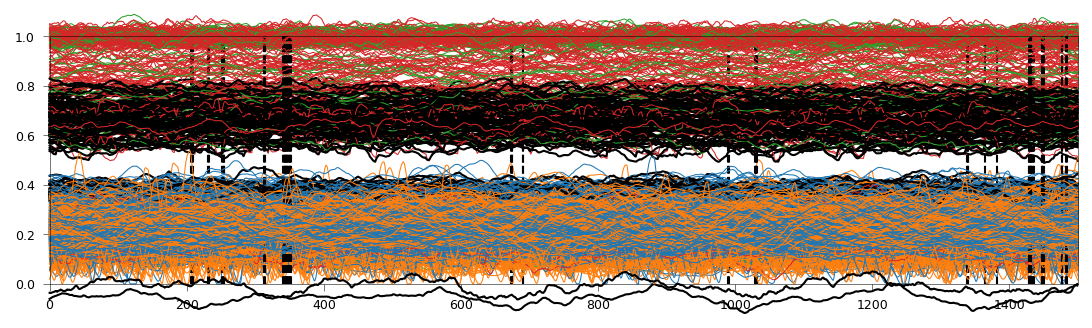

In [8]:
fig, ax = plt.subplots(figsize=(18 * params.cm, 5 * params.cm), dpi=150)
for item in non_empty:
    ar = np.array(item[0])
    for i in range(ar.shape[1]):
        speeds = []
        for d in ar[start::1, -(i + 1)]:
            v_max = ov(params.d_max, d["lam"], d["v0"], d["d"])
            speed = d["vel"][0] / v_max
            speeds.append(speed)
        if d["mode"] == "Car":
            if d["pos"][1] > 0:
                c = "tab:blue"
            else:
                c = "tab:orange"
        else:
            if d["lam"] > 2:
                c = "tab:red"
                c = "tab:red"
            else:
                c = "tab:green"
            # print(d["lam"])
        plt.plot(speeds, c=c, lw=0.5, clip_on=False)
    if n_moto > 0:
        l_DPhi = []
        for t, frame in enumerate(item[0]):
            if t > start:
                deg_range = []
                vel_car = []
                vel_x = []
                vel_y = []
                for j, _ in enumerate(frame):
                    vel = frame[j]["vel"]
                    v0 = frame[j]["v0"]
                    lam = frame[j]["lam"]
                    d = frame[j]["d"]
                    v_max = ov(params.d_max, lam, v0, d)
                    if frame[j]["mode"] == "Car":
                        vel_car.append(vel[0] / v_max)
                    else:
                        alphas = decay(array(vel), frame[j]["theta"])
                        degs = np.degrees(alphas)
                        deg_range.append(degs[0] - degs[-1])
                        vel_x.append(vel[0] / v_max)
                        vel_y.append(vel[1] / v_max)
                phi_cars = mean(vel_car)
                phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
                l_DPhi.append(phi_moto - phi_cars)
                temperature = np.round(mean(deg_range)) / 2
                if temperature == 40.5:
                    plt.axvline(t - start, c="k", ls="--", lw=1)
        plt.plot(l_DPhi, c="k", lw=1, clip_on=False)
ax.set_xlim(0, ar.shape[0] - (start + 1))
ax.set_ylim(0, 1)
fig.tight_layout(pad=0)

In [15]:
for n, item in enumerate(non_empty):
    # ar = np.array(item[0])
    l_T = []
    l_DPhi = []
    frames = []
    # for item in items:
    # if isinstance(item[0], list):
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range = []
            vel_car = []
            vel_x = []
            vel_y = []
            for j, _ in enumerate(frame):
                vel = frame[j]["vel"]
                v0 = frame[j]["v0"]
                lam = frame[j]["lam"]
                d = frame[j]["d"]
                v_max = ov(params.d_max, lam, v0, d)
                if frame[j]["mode"] == "Car":
                    vel_car.append(vel[0] / v_max)
                else:
                    alphas = decay(array(vel), frame[j]["theta"])
                    degs = np.degrees(alphas)
                    deg_range.append(degs[0] - degs[-1])
                    vel_x.append(vel[0] / v_max)
                    vel_y.append(vel[1] / v_max)
            if np.round(mean(deg_range)) / 2 == 40.5:
                # print(t)
                frames.append(t)
                l_T.append(mean(deg_range))
                phi_cars = mean(vel_car)
                phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
                l_DPhi.append(phi_moto - phi_cars)
    l_T = np.round(l_T) / 2
    if len(l_T) > 0:
        print(n)

47
121


In [19]:
ind = 121
item = non_empty[ind]
l_T = []
l_DPhi = []
frames = []
# for item in items:
# if isinstance(item[0], list):
for t, frame in enumerate(item[0]):
    if t > start:
        deg_range = []
        vel_car = []
        vel_x = []
        vel_y = []
        for j, _ in enumerate(frame):
            vel = frame[j]["vel"]
            v0 = frame[j]["v0"]
            lam = frame[j]["lam"]
            d = frame[j]["d"]
            v_max = ov(params.d_max, lam, v0, d)
            if frame[j]["mode"] == "Car":
                vel_car.append(vel[0] / v_max)
            else:
                alphas = decay(array(vel), frame[j]["theta"])
                degs = np.degrees(alphas)
                deg_range.append(degs[0] - degs[-1])
                vel_x.append(vel[0] / v_max)
                vel_y.append(vel[1] / v_max)
        if np.round(mean(deg_range)) / 2 == 40.5:
            # print(t)
            frames.append(t)
            l_T.append(mean(deg_range))
            phi_cars = mean(vel_car)
            phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
            l_DPhi.append(phi_moto - phi_cars)
l_T = np.round(l_T) / 2

In [20]:
# l_T

In [21]:
# l_DPhi

In [22]:
def draw(agent, ax):
    """Add this Particle's Ellipse patch to the Matplotlib Axes ax."""
    if agent["mode"] == "Car":
        width = 2 * params.car_l
        height = 2 * params.car_w
    else:
        width = 2 * params.moto_l
        height = 2 * params.moto_w
    ellipse = Ellipse(
        xy=agent["pos"],
        width=width,
        height=height,
        angle=degrees(agent["theta"]),
        **{"ec": "k", "fc": "w"},
    )
    ax.add_patch(ellipse)
    ax.scatter(
        agent["pos"][0],
        agent["pos"][1],
        marker="o",
        fc="k",
        ec="none",
        s=5,
    )
    if norm(agent["vel"]) > 0:
        ax.arrow(
            agent["pos"][0],
            agent["pos"][1],
            agent["vel"][0],
            agent["vel"][1],
            antialiased=True,
            width=0.1,
            head_width=0.5,
            head_length=0.75,
            color="k",
            zorder=2,
        )

In [23]:
def ring(t, l_agents, ax):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-params.L / 2, params.L / 2)
    ax.set_ylim(-params.lane, params.lane)
    ax.set_axis_off()
    ax.hlines(
        [-params.lane, params.lane],
        xmin=-params.L / 2,
        xmax=params.L / 2,
        color="k",
        ls="-",
        lw=3,
    )
    for agent in l_agents[t]:
        if agent["pos"][0] < params.d_max:
            image = deepcopy(agent)
            image["pos"][0] += params.L
            draw(image, ax)
        elif agent["pos"][0] > params.d_max:
            image = deepcopy(agent)
            image["pos"][0] -= params.L
            draw(image, ax)
        draw(agent, ax)

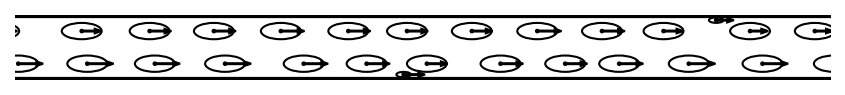

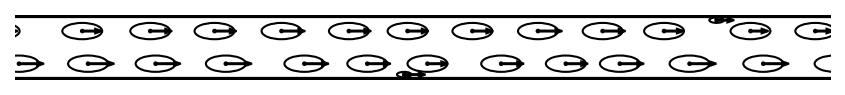

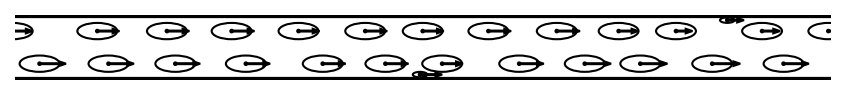

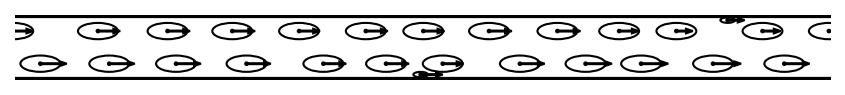

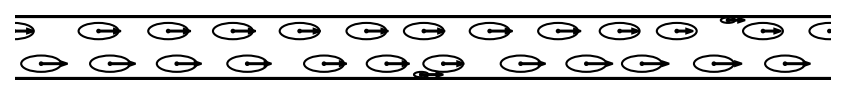

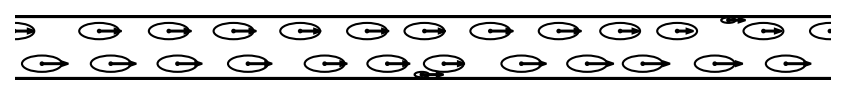

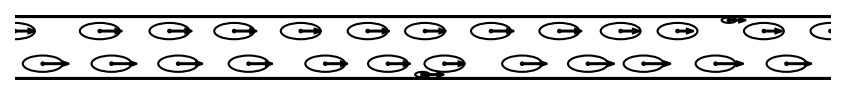

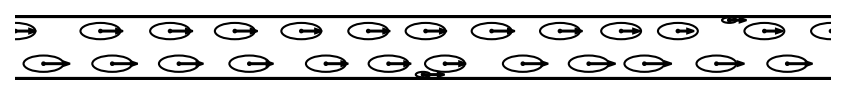

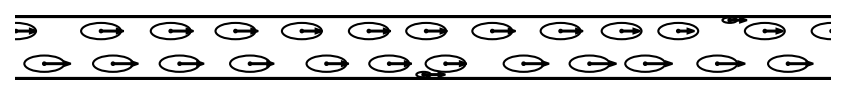

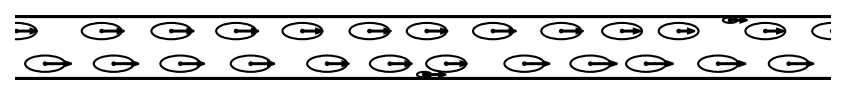

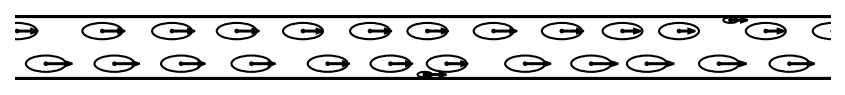

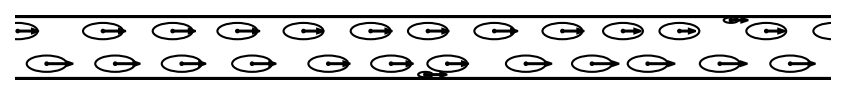

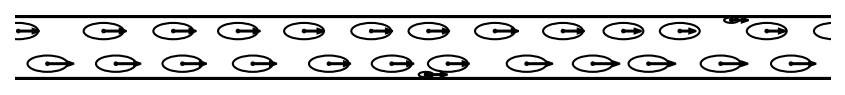

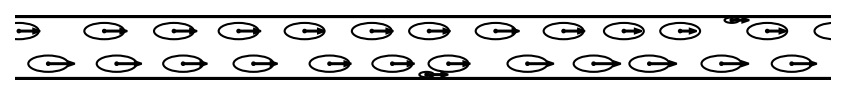

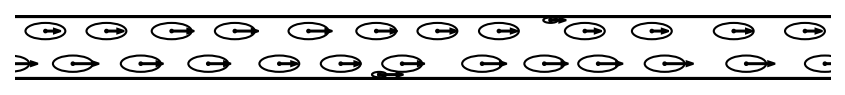

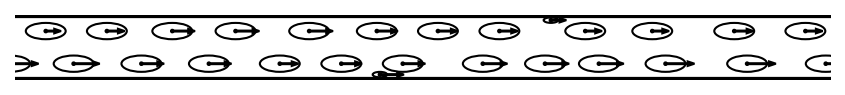

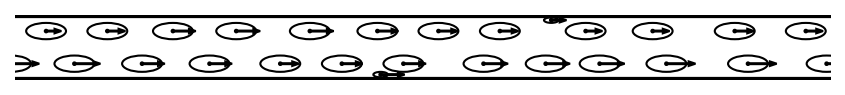

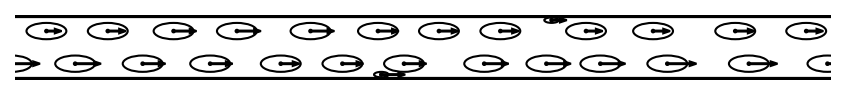

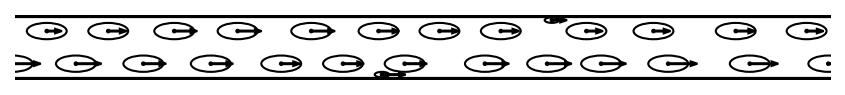

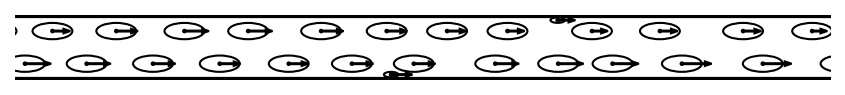

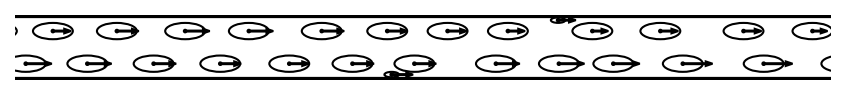

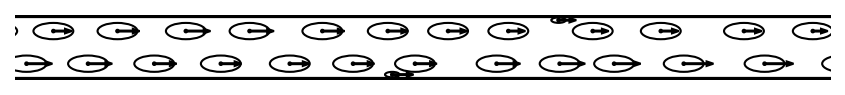

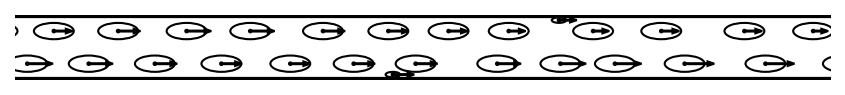

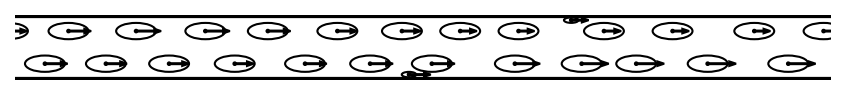

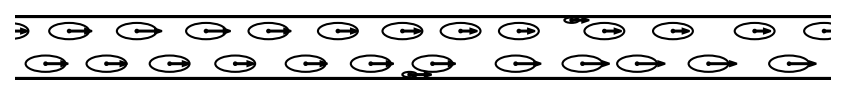

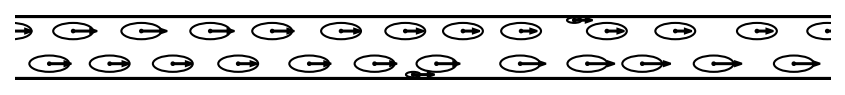

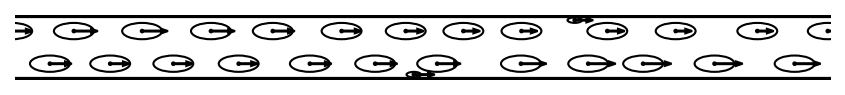

In [24]:
for frame in frames[:]:
    fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
    fig.tight_layout(pad=0)
    ax.set_aspect("equal")
    ring(int(frame), item[0], ax)